In [2]:
!pip install konlpy wordcloud matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.1/494.1 kB 21.8 MB/s eta 0:00:00


In [12]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (11.0 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 126102 files and direc

In [13]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')

In [30]:
# 라이브러리 import
import pandas as pd
import re
import numpy as np
from konlpy.tag import Okt
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 1. 데이터 로드 및 전처리
# 데이터셋 경로 설정
naver_file_path = '/content/navermap_restaurant_reviews_data.xlsx'
review_labeled_path = '/content/review_labeled.xlsx'

# 엑셀 파일 읽기
naver_df = pd.read_excel(naver_file_path)
review_labeled_df = pd.read_excel(review_labeled_path)

# 두 데이터프레임의 리뷰 열 병합
df = pd.concat([
    naver_df[['리뷰']].rename(columns={'리뷰': 'review'}),
    review_labeled_df[['Sentence']].rename(columns={'Sentence': 'review'})
], ignore_index=True)
# 결측치 제거
df = df.dropna(subset=['review'])

# 이모지 및 특수문자 제거 함수
def clean_text(text):
    # 이모지 제거
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)

    # 특수문자, 숫자 제거
    text = re.sub(r'[^가-힣\s]', '', text)

    return text

# 텍스트 정제
df['cleaned_review'] = df['review'].apply(clean_text)

# 데이터 로드 및 전처리 결과 확인
print("데이터 로드 및 전처리 완료")
print("원본 데이터프레임 shape:", df.shape)
print("\n원본 리뷰:")
print(df['review'].head())
print("\n정제된 리뷰:")
print(df['cleaned_review'].head())

데이터 로드 및 전처리 완료
원본 데이터프레임 shape: (2923, 2)

원본 리뷰:
1     쭈꾸미가 탱글탱글하고 양도 많고 구성도 알찼어요😋 적당히 매콤해서 맵찔이도 맛있게 ...
3     쭈꾸미 삼겹살 신촌맛집. 레트로한 분위기와 잘 어울리는 홍합탕, 콘치즈, 계란찜 등...
4     아주 추천하는 곳입니다~ 쭈꾸미 맛있어요! 쭈꾸미 통통하고 크고. 소스가 적당히 딱...
6                             푸짐하도 싱싱하고 친절한 신촌 쭈꾸미 맛집 🐙
11                                               넘흐맛있어요
Name: review, dtype: object

정제된 리뷰:
1     쭈꾸미가 탱글탱글하고 양도 많고 구성도 알찼어요 적당히 매콤해서 맵찔이도 맛있게 먹...
3     쭈꾸미 삼겹살 신촌맛집 레트로한 분위기와 잘 어울리는 홍합탕 콘치즈 계란찜 등 깻잎...
4     아주 추천하는 곳입니다 쭈꾸미 맛있어요 쭈꾸미 통통하고 크고 소스가 적당히 딱 매운...
6                              푸짐하도 싱싱하고 친절한 신촌 쭈꾸미 맛집 
11                                               넘흐맛있어요
Name: cleaned_review, dtype: object


In [35]:
# 2. 형태소 분석 및 명사 추출
# Okt 형태소 분석기 초기화
okt = Okt()

# 불용어 목록
stopwords = ['음식', '맛집', '먹었어요', '먹었네요', '먹었다', '좋아요', '너무', '정말', '진짜', '존맛', '사장', '여기']

# 명사 추출 함수
def get_nouns(text):
    # 명사 추출
    nouns = okt.nouns(text)

    # 불용어 제거 및 2글자 이상 단어만 선택
    nouns = [noun for noun in nouns if noun not in stopwords and len(noun) > 1]

    return nouns

# 명사 추출 적용
df['nouns'] = df['cleaned_review'].apply(get_nouns)

# 형태소 분석 결과 확인
print("\n형태소 분석 결과:")
print("첫 5개 리뷰의 명사 추출 결과:")
for i in range(5):
    print(f"리뷰 {i+1}: {df['nouns'].iloc[i]}")


형태소 분석 결과:
첫 5개 리뷰의 명사 추출 결과:
리뷰 1: ['쭈꾸미', '양도', '구성', '매콤', '볶음밥', '치즈', '계란', '미네', '서도']
리뷰 2: ['쭈꾸미', '삼겹살', '신촌', '레트로', '분위기', '홍합', '콘치', '계란찜', '깻잎', '쭈꾸미', '마요네즈', '소스', '마지막', '치즈', '볶음밥', '양념', '계란', '치즈', '배합', '완벽', '볶음밥', '치즈', '볶음밥']
리뷰 3: ['아주', '추천', '쭈꾸미', '쭈꾸미', '소스', '셀프', '눈치', '보지', '방문']
리뷰 4: ['신촌', '쭈꾸미']
리뷰 5: []


In [38]:
# 3. 단어 빈도 분석
# 모든 명사 평탄화
all_nouns = [noun for nouns in df['nouns'] for noun in nouns]

# 단어 빈도 계산
word_counts = Counter(all_nouns)

# 상위 20개 단어 출력
print("\n단어 빈도 분석:")
print("상위 20개 단어:")
for word, count in word_counts.most_common(20):
    print(f"{word}: {count}")


단어 빈도 분석:
상위 20개 단어:
쭈꾸미: 112
가격: 103
볶음밥: 98
신촌: 97
고기: 95
직원: 87
분위기: 86
방문: 80
가게: 67
최고: 65
메뉴: 64
가성: 64
그냥: 60
별로: 57
서비스: 57
생각: 56
주문: 53
사람: 50
치즈: 49
기분: 49


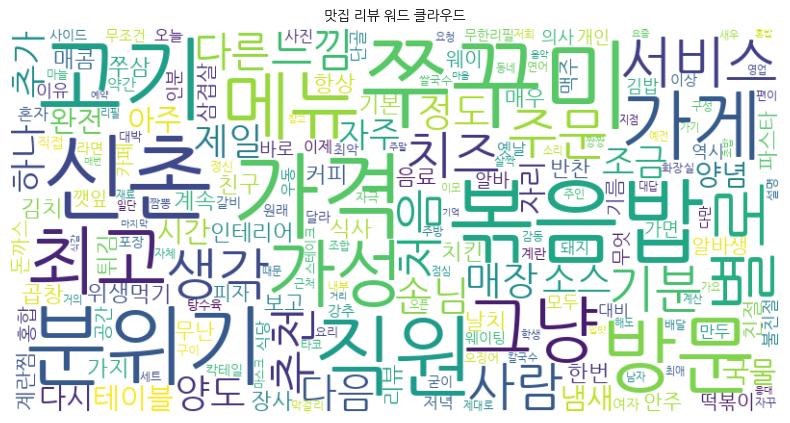

In [39]:
# 라이브러리 import
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 폰트 경로 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

# matplotlib 한글 폰트 설정
plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

# 폰트 설정
font_prop = fm.FontProperties(fname=font_path)

# WordCloud 생성
wordcloud = WordCloud(
    font_path=font_path,
    width=800,
    height=400,
    background_color='white',
    max_font_size=100,
    random_state=42
).generate_from_frequencies(word_counts)

# 시각화
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

# 타이틀에 폰트 속성 적용
plt.title('맛집 리뷰 워드 클라우드', fontsize=16, fontproperties=font_prop)

# 이미지 저장
plt.savefig('/content/wordcloud.png', dpi=300, bbox_inches='tight')
plt.show()